In [2]:
import cupy as cp
import matplotlib.pyplot as plt
from functions import R,RT,mshow_complex,mshow
from phantom import *

import cupyx.scipy.ndimage as ndimage

# load object, the object should be complex64

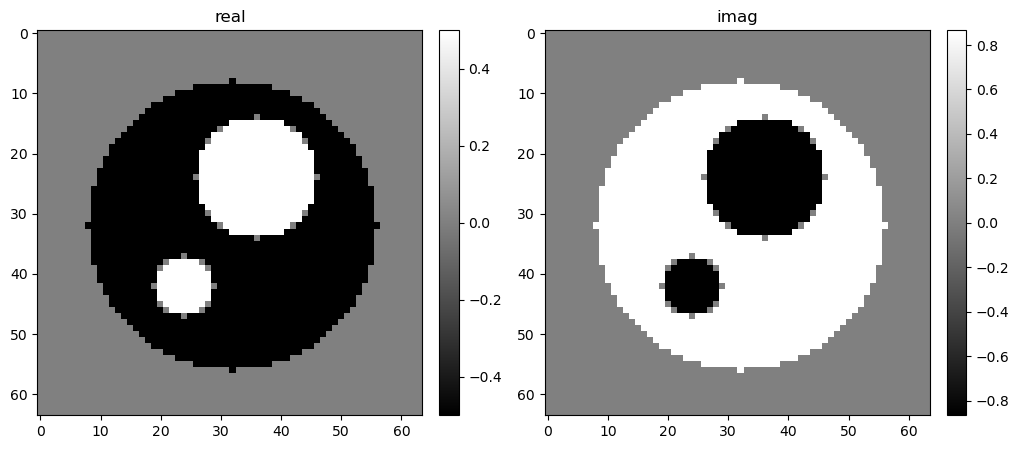

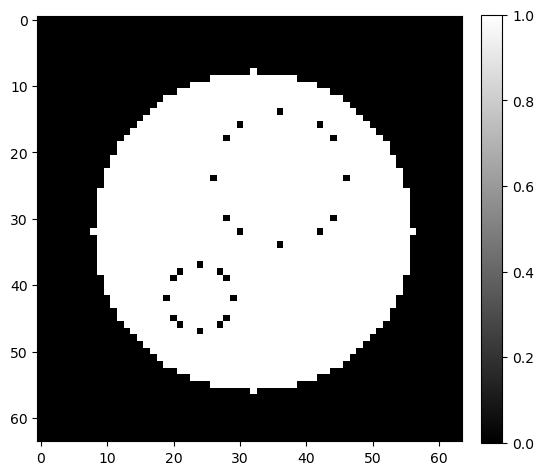

In [4]:
scale = 1
shape = (scale*64, scale*64)
centers = np.array([
    (scale*32, scale*32),  # Center of first circle
    (scale*24, scale*36),  # Center of second circle
    (scale*42, scale*24),  # Center of third circle
])
radii = np.array([
    scale*24,  # Radius of first circle
    scale*10,  # Radius of second circle
    scale*5,   # Radius of third circle
])
# domains = np.array([
#     [1.0, 0.0],   # Direction of first circle
#     [0.0, -1.0],   # Direction of second circle
#     [-1.0, 1.0],   # Direction of third circle
# ])

sphi = np.pi/6+np.pi/2
domains = np.array([
    [np.cos(sphi),np.sin(sphi)],   # Direction of first circle
    [-np.cos(sphi),-np.sin(sphi)],   # Direction of first circle
    [-np.cos(sphi),-np.sin(sphi)],   # Direction of first circle
])

 
# Create the phantom
field, mask = create_vector_field_phantom(
    shape, centers, radii, domains, transition_width=scale*1.0)

w=cp.tile(field,(1,1,1,1)).astype('float32')
mshow_complex(w[w.shape[0]//2,:,:,0]+1j*w[w.shape[0]//2,:,:,1])
# plt.quiver(x[0,:,:,0].get(),x[0,:,:,1].get())
plt.show()


## tomography pars
theta = cp.linspace(0,2*cp.pi/3,60,endpoint=True).astype('float32')
rotation_axis = w.shape[1]/2

mshow(np.linalg.norm(w[0],axis=-1),True)


# Make operators

In [3]:

def F1(x):
    xc = x[:,:,:,0]+1j*x[:,:,:,1]
    Rx =  R(xc,theta,rotation_axis)
    wc = -cp.cos(theta)[:,cp.newaxis]
    ws = -cp.sin(theta)[:,cp.newaxis]
    Fx = Rx.real*ws+Rx.imag*wc
    return Fx
   
def F1adj(Fx):
    wc = -cp.cos(theta)[:,cp.newaxis]
    ws = -cp.sin(theta)[:,cp.newaxis]
    Rx = Fx*ws+1j*Fx*wc
    xc = RT(Rx,theta,rotation_axis)
    x = cp.zeros([*xc.shape,2],dtype='float32')
    x[...,0] = xc.real
    x[...,1] = xc.imag
    return x

def F2(x):
    w,phi = x
    ax=w[...,0]*cp.cos(phi)+w[...,1]*cp.sin(phi)
    return ax

def dF2(x,dx):
    w,phi = x
    dw1,dphi1 = dx
    t1 = cp.cos(phi)*dw1[...,0]
    t2 = cp.sin(phi)*dw1[...,1]
    t3 = (-cp.sin(phi)*w[...,0]+cp.cos(phi)*w[...,1])*dphi1
    return t1+t2+t3

def d2F2(x,dx,dy):
    w,phi = x
    dw1,dphi1 = dx
    dw2,dphi2 = dy
    t1 = -cp.sin(phi)*(dw1[...,0]*dphi2+dw2[...,0]*dphi1)
    t2 = cp.cos(phi)*(dw1[...,1]*dphi2+dw2[...,1]*dphi1)
    t3 = -(cp.cos(phi)*w[...,0]+cp.sin(phi)*w[...,1])*dphi1*dphi2
    return t1+t2+t3
    
def dF2adj(x,ax):
    [w,phi] = x
    gw = cp.zeros([*ax.shape,2],dtype='float32')
    gw[...,0] = cp.cos(phi)*ax
    gw[...,1] = cp.sin(phi)*ax
    gphi = (-cp.sin(phi)*w[...,0]+cp.cos(phi)*w[...,1])*ax
    gphi = cp.sum(gphi)
    
    return [gw,gphi]

# Check approx

0.0 0.0
1.264033957166607 0.34317731983359706
2.528067914333214 0.6863546396671941
3.7921018714998214 1.0295319595007912
5.056135828666428 1.3727092793343882
6.320169785833035 1.7158865991679852
7.584203742999643 2.0590639190015825
8.84823770016625 2.4022412388351797
10.112271657332856 2.7454185586687765
11.376305614499463 3.0885958785023737
12.64033957166607 3.4317731983359705
13.904373528832677 3.7749505181695677
15.168407485999285 4.118127838003165
16.432441443165892 4.461305157836763
17.6964754003325 4.804482477670359
18.960509357499106 5.147659797503956
20.224543314665713 5.490837117337553
21.48857727183232 5.834014437171151
22.752611228998926 6.177191757004747
24.016645186165533 6.520369076838345


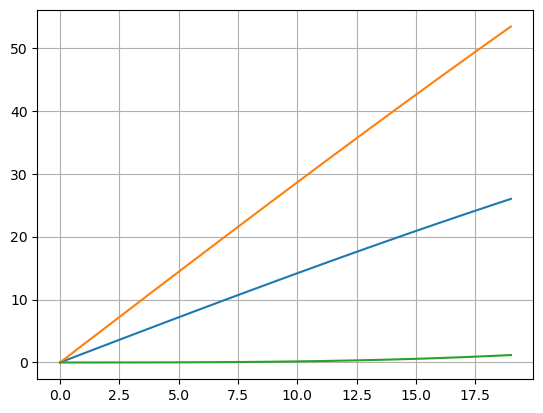

In [4]:
t = cp.random.random(w.shape).astype('float32')
dt0 = cp.random.random(w.shape).astype('float32')/10
phi0 = cp.random.random(1).astype('float32')
dphi0 = cp.random.random(1).astype('float32')/3

l = cp.linspace(0,5,20)
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dt = l[k]*dt0
    dphi = l[k]*dphi0
    a = F2([t+dt,phi0+dphi])
    print(cp.linalg.norm(dF2([t,phi0],[dt,0*dphi])),cp.linalg.norm(dF2([t,phi0],[0*dt,dphi])))
    err1[k] = cp.linalg.norm(F2([t,phi0])-a)
    err2[k] = cp.linalg.norm(F2([t,phi0])-dF2([t,phi0],[dt,dphi])-a)    
    err3[k] = cp.linalg.norm(F2([t,phi0])+dF2([t,phi0],[dt,dphi])+0.5*d2F2([t,phi0],[dt,dphi],[dt,dphi])-a)
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.grid()
plt.show()

# debug plot

In [5]:
def plot_debug(vars, etas, top, bottom, alpha, d, lam):
    """Checking second order approximation"""
    w, phi = vars['w'],vars['phi']
    weta, phieta = etas['w'],etas['phi']
    npp = 9
    errt = cp.zeros(npp * 2)
    errt2 = cp.zeros(npp * 2)
    for k in range(0, npp * 2):
        wt = w + (alpha * k / (npp - 1)) * weta
        phit = phi + (alpha * k / (npp - 1)) * phieta
        errt[k] = cp.linalg.norm(F1(wt)-d)**2+lam*cp.linalg.norm(F2([wt,phit]))**2
        
    t = alpha * (cp.arange(2 * npp)) / (npp - 1)
    errt2 = cp.linalg.norm(F1(w)-d)**2+lam*cp.linalg.norm(F2([w,phi]))**2
    errt2 = errt2 - top * t + 0.5 * bottom * t**2
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt.get(),
        ".",
        label="real",
    )
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt2.get(),
        ".",
        label="approx",
    )
    plt.legend()
    plt.grid()
    plt.show()

# BH functions

In [6]:

def gradient(vars,lam,d):
    w,phi = vars['w'],vars['phi']

    # first part
    gw = 2*F1adj(F1(w)-d) 
    
    # second part
    gw0,gphi = dF2adj([w,phi],2*lam*F2([w,phi]))    
    
    # result
    grads = {}
    grads['w'] = gw + gw0
    grads['phi'] = gphi
    return grads

def hessian_F1(vars,grads,etas):
    dw1 = grads['w']
    dw2 = etas['w']
    
    F1y = F1(dw1)
    F1z = F1(dw2)     
    t1 = 2*cp.real(cp.sum(F1y*cp.conj(F1z)))  
    return t1

def hessian_F2(vars,grads,etas,lam):
    w,phi = vars['w'],vars['phi']
    dw1,dphi1 = grads['w'],grads['phi']
    dw2,dphi2 = etas['w'],etas['phi']
    
    dF21 = dF2([w,phi],[dw1,dphi1])
    dF22 = dF2([w,phi],[dw2,dphi2])
    t1 = 2*cp.real(cp.sum(dF21*cp.conj(dF22)))
    
    d2F = d2F2([w,phi],[dw1,dphi1],[dw2,dphi2])
    t2 = 2*cp.real(cp.sum(F2([w,phi])*cp.conj(d2F)))
    return lam*(t1+t2)

def hessian(vars,grads,etas,lam):
    return hessian_F1(vars,grads,etas)+hessian_F2(vars,grads,etas,lam)

def calc_err(vars,lam,d):
    w,phi = vars['w'],vars['phi']
    return cp.linalg.norm(F1(w)-d)**2+lam*cp.linalg.norm(F2([w,phi]))**2

def BH(vars, d, niter,lam):
    err = cp.zeros(niter)
    for i in range(niter):
        
        if i%8==0:
            err[i] = calc_err(vars,lam,d)
            print(i,f'err={err[i]}')
        grads = gradient(vars,lam,d)
        
        if i == 0:
            etas = {}
            etas['w'] = -grads['w']
            etas['phi'] = -grads['phi']
        else:
            top = hessian(vars,grads,etas,lam)
            bottom = hessian(vars,etas,etas,lam)
            beta = top / bottom
            etas['w'] = etas['w'] * beta - grads['w']
            etas['phi'] = etas['phi'] * beta - grads['phi']
            
        top = -cp.sum(grads['w']*cp.conj(etas['w'])).real-cp.sum(grads['phi']*cp.conj(etas['phi'])).real
        bottom = hessian(vars, etas, etas,lam)
        alpha = top / bottom
        # if i%8==0:
        #     plot_debug(vars,etas,top,bottom,alpha,d,lam)

        vars['w'] += alpha * etas['w']
        vars['phi'] += alpha * etas['phi']
    return vars,err


# Generate data

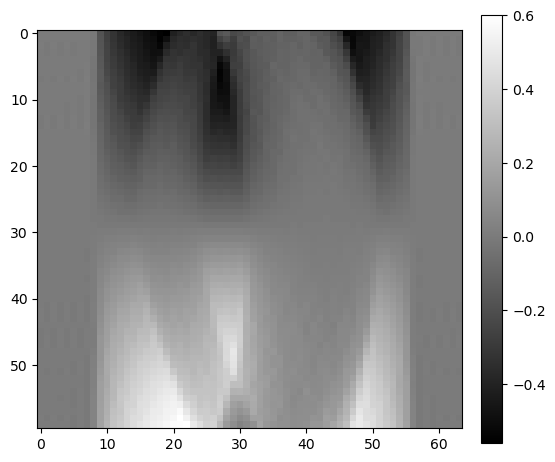

In [7]:
data = F1(w)
# data = data+0.2*(cp.random.random(data.shape)-0.5).astype('float32')
mshow(data[w.shape[0]//2].get())

### Reconstruction $\|R(w)-d\|_2^2+\lambda\|w_x\cos(\phi)+w_y\sin(\phi)\|_2^2$

0 err=131.16148376464844
8 err=0.3743727207183838
16 err=0.16949695348739624
24 err=0.11944206804037094
32 err=0.07227254658937454
40 err=0.04884163662791252
48 err=0.037439990788698196
56 err=0.02876659855246544
64 err=0.020109564065933228
72 err=0.01469507347792387
80 err=0.012111121788620949
88 err=0.010183518752455711
96 err=0.008488109335303307
104 err=0.007033715024590492
112 err=0.005839369259774685
120 err=0.005027486011385918
128 err=0.004372583236545324
136 err=0.0038259054999798536
144 err=0.003337322734296322
152 err=0.0029330493416637182
160 err=0.002599740866571665
168 err=0.002308698371052742
176 err=0.0020972213242202997
184 err=0.0019113686867058277
192 err=0.001749667921103537
200 err=0.0016138425562530756
208 err=0.0014866028213873506
216 err=0.0013693575747311115
224 err=0.0012437563855201006
232 err=0.001144092297181487
240 err=0.0010670659830793738
248 err=0.0009931621607393026
256 err=0.0009196402970701456
vars['phi']=array(0.5259415, dtype=float32)


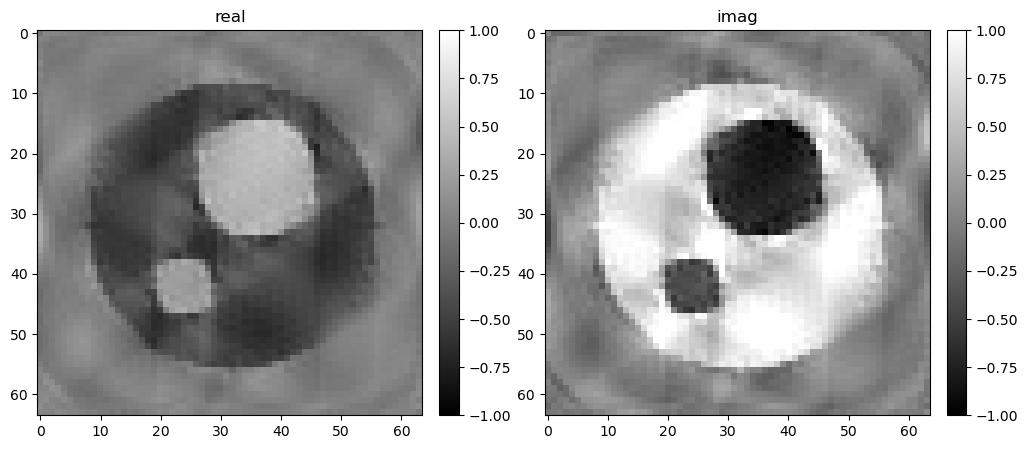

In [8]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
lam = 0.0006
niter = 257
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][0,:,:,0]+1j*vars['w'][0,:,:,1],vmax=1,vmin=-1)

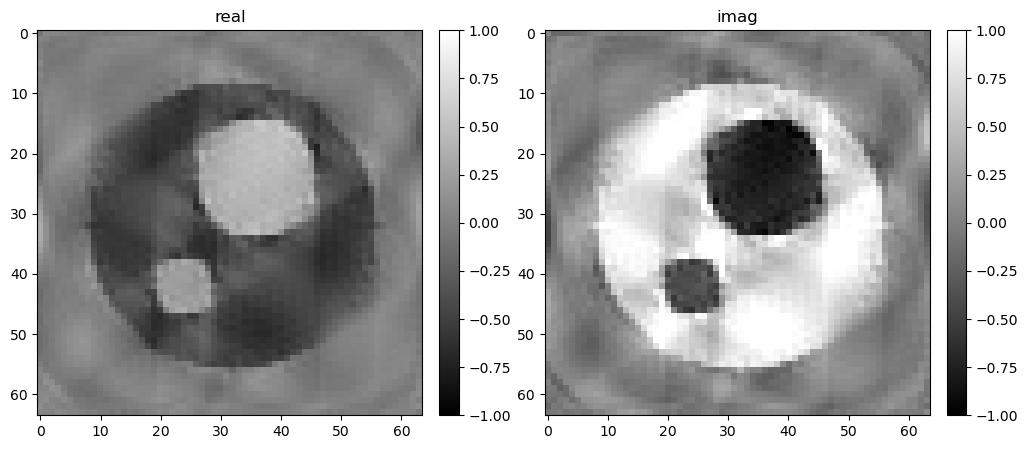

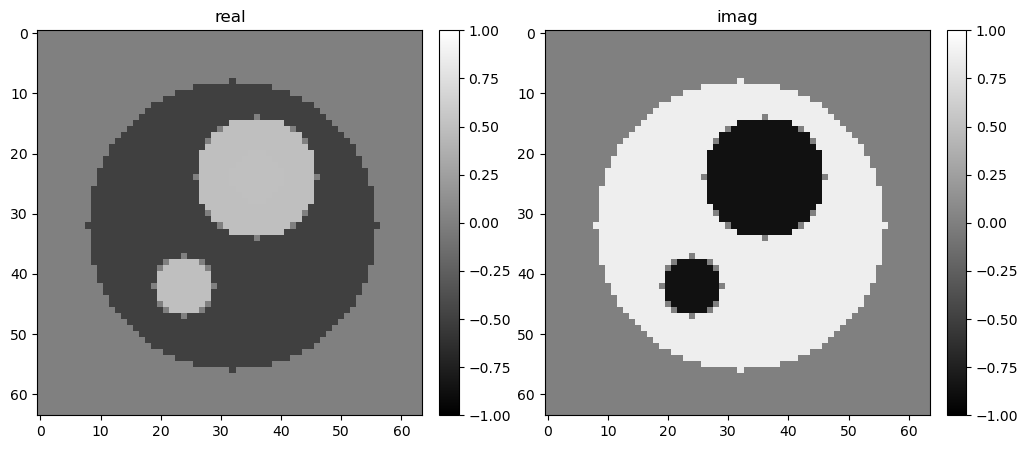

In [9]:
mshow_complex(vars['w'][0,:,:,0]+1j*vars['w'][0,:,:,1],vmax=1,vmin=-1)
mshow_complex(w[0,:,:,0]+1j*w[0,:,:,1],vmax=1,vmin=-1)

In [10]:
vars['phi']

array(0.5259415, dtype=float32)

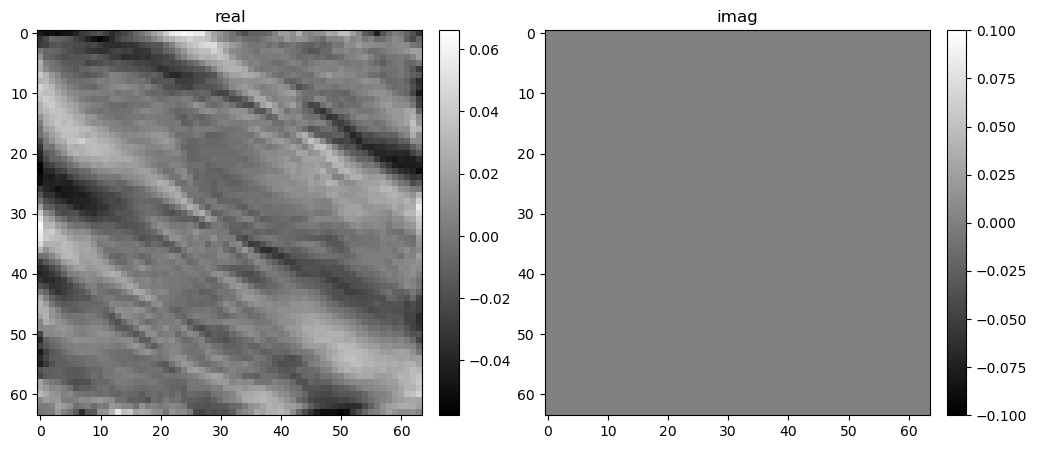

: 

In [ ]:
mshow_complex(F2([vars['w'],vars['phi']])[0])